In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Dict, Any, List, Optional,Literal
from langchain_core.messages import BaseMessage, HumanMessage,SystemMessage,AIMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from datetime import date
from enum import Enum

In [3]:
load_dotenv()

True

In [4]:
class GoalCreate(BaseModel):
    goal_name: str = Field(..., max_length=200)
    description: Optional[str] = None
    start_date : date = Field(default_factory=date.today)
    target_date: Optional[date] = None

    importance_level: int = Field(default=1, ge=1, le=5)
    motivations: Optional[List[str]] = None

In [5]:

class SubtaskType(str, Enum):
    checkbox = "checkbox"
    count = "count"
    duration = "duration"
    score = "score"


class GeneratedSubtask(BaseModel):
    temp_subtask_key: str

    subtask_name: str
    subtask_type: SubtaskType

    target_value: Optional[float] = None
    weight: int = 1
    deadline: Optional[date] = None

    depends_on_subtask_key: Optional[str] = None


class GeneratedTask(BaseModel):
    temp_task_key: str

    task_name: str
    description: Optional[str] = None
    difficulty: int = Field(ge=1, le=5)

    depends_on_task_key: Optional[str] = None
    subtasks: List[GeneratedSubtask]


class RoutineGenerationOutput(BaseModel):
    tasks: List[GeneratedTask]


In [6]:
GOAL_PROMPT_SYSTEM = """
You are a goal normalization engine.

Your task:
- Convert informal user input into a structured goal.

Rules:
- goal_name must be concise and specific
- description should expand what the user wants to achieve
- start_date is always today unless user specified that i want to start from a date in future
- target_date:
  - infer ONLY if user explicitly mentions a time (e.g. "2022-12-25") use current time as reference if user mentions duration to evaluate target date
  - otherwise set it to null
- importance_level:
  - infer urgency (1 = casual, 5 = very important)
- motivations:
  - infer clear motivations if stated or obvious
  - otherwise null

Do NOT ask questions.
Do NOT add extra fields.
Return ONLY structured output.
"""

In [7]:
ROUTINE_SYSTEM_PROMPT = """
You are a routine generation engine.

Generate:
1. Tasks and subtasks ONLY in structured form
2. High-level suggestions for the user as text

Rules:
- Tasks must match Task + Subtask schema
- No IDs, no completion fields
- Use temporary keys for dependencies
"""


In [11]:
class RoutineSuggestions(BaseModel):
    suggestions: List[str]

In [12]:
class RoutineLLMOutput(BaseModel):
    routine: RoutineGenerationOutput
    suggestions: RoutineSuggestions


In [13]:
class EvaluatorOutput(BaseModel):
    feedback: str
    approved: bool

In [14]:


Int1to10 = Annotated[int, Field(ge=1, le=10)]
Int1to7 = Annotated[int, Field(ge=1, le=7)]
Int0to6 = Annotated[int, Field(ge=0, le=6)]
Int15to180 = Annotated[int, Field(ge=15, le=180)]
Int4to12 = Annotated[int, Field(ge=4, le=12)]


class Intensity(BaseModel):
    level: Literal["low", "moderate", "high"]
    rpe_range: List[Int1to10] = Field(
        min_length=2,
        max_length=2,
        description="RPE range [min, max]"
    )


class WeeklyStructure(BaseModel):
    workout_days: Int1to7
    rest_days: Int0to6


class Recovery(BaseModel):
    sleep_hours: Int4to12
    active_recovery: bool


class FitnessPlan(BaseModel):
    # ---------------- Goal & experience ----------------
    goal: Literal["fat_loss", "muscle_gain", "endurance"]
    experience_level: Literal["beginner", "intermediate", "advanced"]

    # ---------------- Frequency & duration ----------------
    weekly_frequency: Int1to7
    session_duration_min: Int15to180

    # ---------------- Training structure ----------------
    training_split: Literal[
        "full_body",
        "upper_lower",
        "push_pull_legs"
    ]

    workout_types: List[
        Literal["strength", "cardio", "mobility"]
    ]

    # ---------------- Load & recovery ----------------
    intensity: Intensity
    weekly_structure: WeeklyStructure

    # ---------------- Preferences & constraints ----------------
    exercise_preferences: List[str] = Field(default_factory=list)
    exercise_constraints: List[str] = Field(default_factory=list)

    # ---------------- Progression ----------------
    progression_strategy: Literal[
        "linear", "wave", "autoregulatory"
    ]

    recovery: Recovery

    # ---------------- Safety & adherence ----------------
    safety_notes: List[str] = Field(default_factory=list)
    compliance_level: Literal["strict", "flexible"]


In [15]:
routine_llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.3
)
routine_structured_llm = routine_llm.with_structured_output(
    RoutineLLMOutput
)

In [16]:
fitness_planer_llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.3
)
structured_fitness_planer_llm = fitness_planer_llm.with_structured_output(
    FitnessPlan
)

In [17]:
from enum import Enum


class Intent(str, Enum):
    GOAL = "goal"
    FITNESS = "fitness"
    DIET = "diet"

    PLAN_DAY = "plan_day"

    ANALYZE_PRODUCTIVITY = "analyze_productivity"
    ASK_REFLECTION = "ask_reflection"

    UPDATE_FITNESS_PLAN = "update_fitness_plan"
    UPDATE_DIET_PLAN = "update_diet_plan"

    GENERAL_QUERY = "general_query"


In [18]:
class IntentResolutionOutput(BaseModel):
    intent: Intent

In [19]:
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.7
)

#goal prompt 
goal_prompt_llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.1   # low temp = deterministic normalization
)

goal_prompt_structured_llm = goal_prompt_llm.with_structured_output(
    GoalCreate
)

intent_resolver_llm = llm.with_structured_output(
    IntentResolutionOutput)

In [20]:
evaluator_llm = ChatGroq(
    model="openai/gpt-oss-120b")
evaluator_structured_llm = evaluator_llm.with_structured_output(
    EvaluatorOutput
)

In [21]:
from langgraph.graph import add_messages
class ChatState(TypedDict, total=False):
    messages: Annotated[List[BaseMessage], add_messages]

    intent: str

    structured_goal: Dict[str, Any]   # GoalCreate output
    routine_tasks: List[Dict[str, Any]]

    fitness_plan: Dict[str, Any]        # active fitness plan only
    diet_plan: Dict[str, Any]           # active diet plan only

    feedback: str
    approved: bool

    # loop / control info
    iteration: int
    max_iterations: int

In [22]:
def goal_prompt_builder_node(state:ChatState
) -> ChatState:
    """
    Converts user input into GoalCreate schema.
    """
    print("Routine generator node input state")
    user_text = state["messages"][-1].content

    messages = [
        SystemMessage(content=GOAL_PROMPT_SYSTEM),
        HumanMessage(content=user_text),
    ]
    print("Messages to goal LLM:", messages)
    goal: GoalCreate = goal_prompt_structured_llm.invoke(messages)
    print("Goal LLM output:", goal)
    # update state with structured goal
    new_state = {
        **state,
        "structured_goal": goal.model_dump()
    }

    # optional: confirmation message for UI
    confirmation = (
        "I’ve understood your goal as:\n\n"
        f"🎯 Goal: {goal.goal_name}\n"
        f"📝 Description: {goal.description or '—'}\n"
        f"📅 Target Date: {goal.target_date or 'Not specified'}\n"
        f"⭐ Importance Level: {goal.importance_level}/5\n"
    )

    if goal.motivations:
        confirmation += "💡 Motivations:\n"
        for m in goal.motivations:
            confirmation += f"• {m}\n"

    new_state["messages"] = [
        AIMessage(content=confirmation)
    ]

    return new_state

In [23]:


def routine_generator_node(
    state: ChatState
) -> ChatState:
    
    goal = state["messages"][-1].content  # user goal text

    messages = [
        SystemMessage(content=ROUTINE_SYSTEM_PROMPT),
        HumanMessage(content=goal)
    ]
    print("Messages to routine LLM:", messages)
    llm_output = routine_structured_llm.invoke(messages)
    print("Routine LLM output:", llm_output)
    # 1️⃣ Structured routine → state
    new_state = {
        **state,
        "routine_tasks": llm_output.routine.tasks
    }

    # 2️⃣ Suggestions → chat message
    suggestion_text = "\n".join(
        f"- {s}" for s in llm_output.suggestions.suggestions
    )

    new_state["messages"] = [
        AIMessage(
            content=f"Here are some suggestions to follow along with this routine:\n{suggestion_text}"
        )
    ]

    return new_state

In [24]:
def goal_evaluator_node(
    state: ChatState
) -> ChatState:
    """
    Evaluates the proposed routine.
    """
    routine = state["routine_tasks"]
    goal = state["structured_goal"]

    evaluation_prompt = f"""
    Given the goal: {goal} and the proposed routine: {routine},
    provide feedback on how well the routine aligns with the goal.
    Suggest improvements if necessary.
    Finally, indicate whether the routine is approved (true/false).
    """

    messages = [
        SystemMessage(content="You are an expert evaluator of routines."),
        HumanMessage(content=evaluation_prompt)
    ]
    print("Messages to evaluator LLM:", messages)
    llm_output = evaluator_structured_llm.invoke(messages)
    print("Evaluator LLM output:", llm_output)

    # Parse output (assuming simple text parsing for demo purposes)
    print(llm_output)
    feedback = llm_output.feedback
    approved = llm_output.approved

    new_state = {
        **state,
        "feedback": feedback,
        "approved": approved
    }

    return new_state

In [25]:
def goal_optimisor_node(
    state: ChatState
) -> ChatState:
    """
    Optimizes the routine based on evaluator feedback.
    """
    routine = state["routine_proposal"]
    feedback = state["feedback"]
    goal = state["structured_goal"]
    optimization_prompt = f"""
    Given the routine: {routine} for the goal {goal} and the following feedback: {feedback},
    make necessary improvements to the routine.
    """

    messages = [
        SystemMessage(content="You are a routine optimization engine."),
        HumanMessage(content=optimization_prompt)
    ]
    print("Messages to optimizer LLM:", messages)
    llm_output = routine_structured_llm.invoke(messages)
    print("Optimizer LLM output:", llm_output)
    iteration = state.get("iteration", 0)
    iteration += 1
    new_state = {
        **state,
        "routine_proposal": llm_output.routine.tasks,
        "iteration": iteration
    }

    return new_state

In [26]:
def conditional_decision(state: ChatState):
    if state['approved'] == False and state['iteration'] < state['max_iterations']:
        return 'need_improvement'
    return 'approved'

In [27]:
def intent_resolver_node(
    state: ChatState
) -> ChatState:
    """
    Resolves user intent to determine if it's fitness or diet related.
    """
    user_text = state["messages"][-1].content
    
    intent_prompt = f"""
    Determine the user's intent from the following text: {user_text}.
    Is the user looking to update their fitness plan, diet plan, or something else?
    - If fitness related, respond with 'fitness'.
    - If diet related, respond with 'diet'.
    - If goal creation related, respond with 'goal'.
    - Otherwise, respond with an empty string.
    """
    messages = [
        SystemMessage(content="You are an intent resolution engine."),
        HumanMessage(content=intent_prompt)
    ]

    llm_output = intent_resolver_llm.invoke(messages)
    
    intent = llm_output.intent
    new_state = {
        **state,
        "intent": intent.value
    }
    return new_state

In [28]:
def fitness_planer_node(
    state: ChatState
) -> ChatState:
    """
    Generates a fitness plan based on the user's prompt what does user want to acheive.
    """

    user_text = state["messages"][-1].content

    fitness_prompt = f"""
    You are a Fitness Planner Agent.

    Your task is to generate a complete, safe, and realistic fitness plan
    to help achieve the user's goal.

    User goal (natural language):
    {user_text}

    --------------------------------------------------
    IMPORTANT OUTPUT RULES
    --------------------------------------------------
    1. Output MUST be valid JSON.
    2. Output MUST strictly follow the FitnessPlan schema.
    3. DO NOT omit any field — every field must be present.
    4. DO NOT include explanations, comments, or extra text.
    5. Use sensible defaults if the user did not specify something.
    6. Assume the user is healthy unless constraints are explicitly stated.

    --------------------------------------------------
    FITNESS PLAN SCHEMA (YOU MUST FOLLOW EXACTLY)
    --------------------------------------------------
    {
    "goal": "fat_loss | muscle_gain | endurance",
    "experience_level": "beginner | intermediate | advanced",

    "weekly_frequency": 1–7,
    "session_duration_min": 15–180,

    "training_split": "full_body | upper_lower | push_pull_legs",
    "workout_types": ["strength", "cardio", "mobility"],

    "intensity": {
        "level": "low | moderate | high",
        "rpe_range": [1–10, 1–10]
    },

    "weekly_structure": {
        "workout_days": 1–7,
        "rest_days": 0–6
    },

    "exercise_preferences": [string],
    "exercise_constraints": [string],

    "progression_strategy": "linear | wave | autoregulatory",

    "recovery": {
        "sleep_hours": 4–12,
        "active_recovery": true | false
    },

    "safety_notes": [string],
    "compliance_level": "strict | flexible"
    }

    --------------------------------------------------
    DEFAULT ASSUMPTIONS (USE IF USER DOES NOT SPECIFY)
    --------------------------------------------------
    • experience_level: "beginner"
    • weekly_frequency: 3
    • session_duration_min: 45
    • training_split: "full_body"
    • workout_types: ["strength", "mobility"]
    • intensity.level: "moderate"
    • intensity.rpe_range: [6, 7]
    • progression_strategy: "linear"
    • recovery.sleep_hours: 7
    • recovery.active_recovery: true
    • compliance_level: "flexible"
    • exercise_preferences: []
    • exercise_constraints: []
    • safety_notes: []

    --------------------------------------------------
    SAFETY & CONSISTENCY RULES
    --------------------------------------------------
    • workout_days MUST equal weekly_frequency
    • workout_days + rest_days MUST equal 7
    • Beginners should not exceed 4 workout days
    • High intensity MUST NOT be used for beginners
    • RPE > 8 only allowed for advanced users
    • Include rest days

    --------------------------------------------------
    FINAL CHECK BEFORE OUTPUT
    --------------------------------------------------
    Before producing output, verify:
    • All fields exist
    • All values are within allowed ranges
    • JSON is syntactically valid

    ONLY OUTPUT THE FINAL JSON.
    """

    messages = [
        SystemMessage(content="You are a fitness plan generation engine."),
        HumanMessage(content=fitness_prompt)
    ]
    print("Messages to fitness planer LLM:", messages)
    llm_output = structured_fitness_planer_llm.invoke(messages)
    print("Fitness Planer LLM output:", llm_output)

    new_state = {
        **state,
        "fitness_plan": llm_output.model_dump()
    }

    return new_state

In [29]:
def fitness_evalautor_node(
    state: ChatState
) -> ChatState:
    """
    Evaluates the generated fitness plan.
    """
    fitness_plan = state["fitness_plan"]
    evaluation_prompt = f"""
    Given the fitness plan: {fitness_plan},
    provide feedback on its effectiveness and safety.
    Suggest improvements if necessary.
    Finally, indicate whether the plan is approved (true/false).
    """

    messages = [
        SystemMessage(content="You are an expert evaluator of fitness plans."),
        HumanMessage(content=evaluation_prompt)
    ]
    
    llm_output = evaluator_structured_llm.invoke(messages)
   

    # Parse output (assuming simple text parsing for demo purposes)
  
    feedback = llm_output.feedback
    approved = llm_output.approved

    new_state = {
        **state,
        "feedback": feedback,
        "approved": approved
    }

    return new_state

In [30]:
def fitness_optimisor_node(
    state: ChatState
) -> ChatState:
    """
    Optimizes the fitness plan based on evaluator feedback.
    """
    fitness_plan = state["fitness_plan"]
    feedback = state["feedback"]
    optimization_prompt = f"""
    Given the fitness plan: {fitness_plan} and the following feedback: {feedback},
    make necessary improvements to the fitness plan.
    """

    messages = [
        SystemMessage(content="You are a fitness plan optimization engine."),
        HumanMessage(content=optimization_prompt)
    ]
    
    llm_output = structured_fitness_planer_llm.invoke(messages)
   
    iteration = state.get("iteration", 0)
    iteration += 1
    new_state = {
        **state,
        "fitness_plan": llm_output.model_dump(),
        "iteration": iteration
    }

    return new_state

In [38]:
graph = StateGraph(ChatState)

# add nodes
graph.add_node('routine_generator_node', routine_generator_node)
graph.add_node('goal_prompt_builder_node', goal_prompt_builder_node)
graph.add_node('goal_evaluator_node', goal_evaluator_node)
graph.add_node('goal_optimisor_node', goal_optimisor_node)
graph.add_node('intent_resolver', intent_resolver_node)
graph.add_node('fitness_planer', fitness_planer_node)
graph.add_node('fitness_evalautor_node', fitness_evalautor_node)
graph.add_node('fitness_optimisor_node', fitness_optimisor_node)
#graph.add_node('diet_planer', diet_planer_node)

graph.add_edge(START , 'intent_resolver')
graph.add_conditional_edges('intent_resolver', intent_resolver_node,{
  'fitness': 'fitness_planer',
  'diet': END,
  'goal': 'goal_prompt_builder_node'
})
graph.add_edge('goal_prompt_builder_node', 'routine_generator_node')
graph.add_edge('routine_generator_node', 'goal_evaluator_node')
graph.add_conditional_edges('goal_evaluator_node',conditional_decision,{'need_improvement':'goal_optimisor_node','approved' : END})
graph.add_edge('goal_optimisor_node', 'goal_evaluator_node')

graph.add_edge('fitness_planer', 'fitness_evalautor_node')
graph.add_conditional_edges('fitness_evalautor_node',conditional_decision,{'need_improvement':'fitness_optimisor_node','approved' : END})
graph.add_edge('fitness_optimisor_node', 'fitness_evalautor_node')

chatbot = graph.compile()

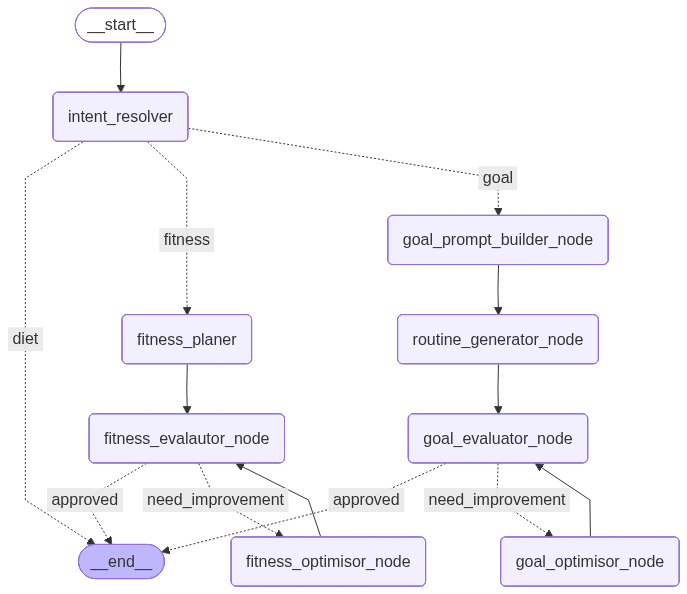

In [39]:
chatbot

In [ ]:
initial_state = {
    'messages': [HumanMessage(content='i want to complete dsa from basics to advance level in 6 months')],
    "iteration": 0,
    "max_iterations": 3
}

chatbot.invoke(initial_state)

Routine generator node input state
Messages to goal LLM: [SystemMessage(content='\nYou are a goal normalization engine.\n\nYour task:\n- Convert informal user input into a structured goal.\n\nRules:\n- goal_name must be concise and specific\n- description should expand what the user wants to achieve\n- start_date is always today unless user specified that i want to start from a date in future\n- target_date:\n  - infer ONLY if user explicitly mentions a time (e.g. "2022-12-25") use current time as reference if user mentions duration to evaluate target date\n  - otherwise set it to null\n- importance_level:\n  - infer urgency (1 = casual, 5 = very important)\n- motivations:\n  - infer clear motivations if stated or obvious\n  - otherwise null\n\nDo NOT ask questions.\nDo NOT add extra fields.\nReturn ONLY structured output.\n', additional_kwargs={}, response_metadata={}), HumanMessage(content='i want to complete dsa from basics to advance level in 6 months', additional_kwargs={}, respon

{'messages': [HumanMessage(content='i want to complete dsa from basics to advance level in 6 months', additional_kwargs={}, response_metadata={}, id='eb4cdf4b-7ae8-4f86-96e5-d804c5cf0ca7'),
  AIMessage(content='I’ve understood your goal as:\n\n🎯 Goal: DSA\n📝 Description: Complete DSA from basics to advance level\n📅 Target Date: 2024-07-01\n⭐ Importance Level: 5/5\n', additional_kwargs={}, response_metadata={}, id='e4b0fa16-5af2-49d4-9dc0-bc6666e05b90'),
  AIMessage(content='Here are some suggestions to follow along with this routine:\n- Create a weekly calendar allocating 1‑2\u202fhours on weekdays and 3‑4\u202fhours on weekends for DSA study.\n- Use a mix of resources: a textbook (e.g., "Introduction to Algorithms"), online courses (Coursera, Udemy), and coding platforms (LeetCode, HackerRank).\n- After completing each subtask, immediately apply the knowledge by solving related problems to reinforce learning.\n- Track progress in a spreadsheet, marking completed subtasks and noting an

In [ ]:
Messages to routine LLM: [SystemMessage(content='\nYou are a routine generation engine.\n\nGenerate:\n1. Tasks and subtasks ONLY in structured form\n2. High-level suggestions for the user as text\n\nRules:\n- Tasks must match Task + Subtask schema\n- No IDs, no completion fields\n- Use temporary keys for dependencies\n- Suggestions must be general advice, not instructions\n', additional_kwargs={}, response_metadata={}), HumanMessage(content='i want to complete dsa from basics to advance level in 6 months', additional_kwargs={}, response_metadata={})]
Routine LLM output: routine=RoutineGenerationOutput(tasks=[GeneratedTask(temp_task_key='t1', task_name='Foundations of Programming & Basic Algorithms', description='Cover programming fundamentals, complexity analysis, and simple algorithmic patterns.', difficulty=2, depends_on_task_key=None, subtasks=[GeneratedSubtask(temp_subtask_key='t1_s1', subtask_name='Read introductory chapters on variables, control flow, and functions', subtask_type=<SubtaskType.duration: 'duration'>, target_value=30.0, weight=1, deadline=datetime.date(2026, 2, 7), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t1_s2', subtask_name='Solve 100 easy coding problems (e.g., arrays, loops)', subtask_type=<SubtaskType.count: 'count'>, target_value=100.0, weight=1, deadline=datetime.date(2026, 2, 28), depends_on_subtask_key='t1_s1'), GeneratedSubtask(temp_subtask_key='t1_s3', subtask_name='Complete weekly quizzes (4 total) with ≥70% score', subtask_type=<SubtaskType.score: 'score'>, target_value=70.0, weight=1, deadline=datetime.date(2026, 2, 28), depends_on_subtask_key='t1_s2')]), GeneratedTask(temp_task_key='t2', task_name='Core Data Structures – Linear', description='Learn and practice arrays, linked lists, stacks, and queues.', difficulty=3, depends_on_task_key='t1', subtasks=[GeneratedSubtask(temp_subtask_key='t2_s1', subtask_name='Watch video lectures on arrays and linked lists', subtask_type=<SubtaskType.duration: 'duration'>, target_value=20.0, weight=1, deadline=datetime.date(2026, 3, 7), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t2_s2', subtask_name='Implement each structure from scratch in your preferred language', subtask_type=<SubtaskType.count: 'count'>, target_value=4.0, weight=1, deadline=datetime.date(2026, 3, 14), depends_on_subtask_key='t2_s1'), GeneratedSubtask(temp_subtask_key='t2_s3', subtask_name='Solve 80 medium‑difficulty problems focusing on these structures', subtask_type=<SubtaskType.count: 'count'>, target_value=80.0, weight=1, deadline=datetime.date(2026, 3, 31), depends_on_subtask_key='t2_s2'), GeneratedSubtask(temp_subtask_key='t2_s4', subtask_name='Pass a short assessment with ≥75% score', subtask_type=<SubtaskType.score: 'score'>, target_value=75.0, weight=1, deadline=datetime.date(2026, 3, 31), depends_on_subtask_key='t2_s3')]), GeneratedTask(temp_task_key='t3', task_name='Recursion, Sorting & Searching', description='Master recursion patterns and classic sorting/searching algorithms.', difficulty=3, depends_on_task_key='t2', subtasks=[GeneratedSubtask(temp_subtask_key='t3_s1', subtask_name='Study recursion concepts and common patterns (divide‑and‑conquer)', subtask_type=<SubtaskType.duration: 'duration'>, target_value=15.0, weight=1, deadline=datetime.date(2026, 4, 7), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t3_s2', subtask_name='Implement and benchmark Bubble, Insertion, Merge, Quick, and Heap sort', subtask_type=<SubtaskType.count: 'count'>, target_value=5.0, weight=1, deadline=datetime.date(2026, 4, 14), depends_on_subtask_key='t3_s1'), GeneratedSubtask(temp_subtask_key='t3_s3', subtask_name='Solve 70 problems involving recursion, sorting, and binary search', subtask_type=<SubtaskType.count: 'count'>, target_value=70.0, weight=1, deadline=datetime.date(2026, 4, 30), depends_on_subtask_key='t3_s2'), GeneratedSubtask(temp_subtask_key='t3_s4', subtask_name='Complete a timed quiz (30\u202fmin) with ≥80% correct answers', subtask_type=<SubtaskType.score: 'score'>, target_value=80.0, weight=1, deadline=datetime.date(2026, 4, 30), depends_on_subtask_key='t3_s3')]), GeneratedTask(temp_task_key='t4', task_name='Advanced Data Structures – Trees & Graphs', description='Deep dive into binary trees, BSTs, AVL/Red‑Black trees, heaps, and graph representations.', difficulty=4, depends_on_task_key='t3', subtasks=[GeneratedSubtask(temp_subtask_key='t4_s1', subtask_name='Read and summarize chapters on trees and graph fundamentals', subtask_type=<SubtaskType.duration: 'duration'>, target_value=25.0, weight=1, deadline=datetime.date(2026, 5, 7), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t4_s2', subtask_name='Implement traversal algorithms (in‑order, pre‑order, post‑order, BFS, DFS)', subtask_type=<SubtaskType.count: 'count'>, target_value=5.0, weight=1, deadline=datetime.date(2026, 5, 14), depends_on_subtask_key='t4_s1'), GeneratedSubtask(temp_subtask_key='t4_s3', subtask_name='Solve 90 problems covering tree operations and basic graph algorithms', subtask_type=<SubtaskType.count: 'count'>, target_value=90.0, weight=1, deadline=datetime.date(2026, 5, 31), depends_on_subtask_key='t4_s2'), GeneratedSubtask(temp_subtask_key='t4_s4', subtask_name='Pass a mini‑project: build a simple path‑finding visualizer', subtask_type=<SubtaskType.checkbox: 'checkbox'>, target_value=None, weight=1, deadline=datetime.date(2026, 5, 31), depends_on_subtask_key='t4_s3')]), GeneratedTask(temp_task_key='t5', task_name='Algorithmic Paradigms – DP, Greedy, Backtracking', description='Learn dynamic programming, greedy strategies, and backtracking techniques.', difficulty=4, depends_on_task_key='t4', subtasks=[GeneratedSubtask(temp_subtask_key='t5_s1', subtask_name='Watch tutorial series on DP, greedy, and backtracking', subtask_type=<SubtaskType.duration: 'duration'>, target_value=20.0, weight=1, deadline=datetime.date(2026, 6, 7), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t5_s2', subtask_name='Create a cheat‑sheet of state‑definition patterns for DP', subtask_type=<SubtaskType.checkbox: 'checkbox'>, target_value=None, weight=1, deadline=datetime.date(2026, 6, 10), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t5_s3', subtask_name='Solve 100 mixed‑difficulty problems focusing on these paradigms', subtask_type=<SubtaskType.count: 'count'>, target_value=100.0, weight=1, deadline=datetime.date(2026, 6, 30), depends_on_subtask_key='t5_s2'), GeneratedSubtask(temp_subtask_key='t5_s4', subtask_name='Take a comprehensive test (90\u202fmin) with ≥75% score', subtask_type=<SubtaskType.score: 'score'>, target_value=75.0, weight=1, deadline=datetime.date(2026, 6, 30), depends_on_subtask_key='t5_s3')]), GeneratedTask(temp_task_key='t6', task_name='Mock Interviews, Review & Polish', description='Simulate interview conditions, identify gaps, and reinforce weak topics.', difficulty=5, depends_on_task_key='t5', subtasks=[GeneratedSubtask(temp_subtask_key='t6_s1', subtask_name='Complete 5 full‑length mock interview sessions', subtask_type=<SubtaskType.count: 'count'>, target_value=5.0, weight=1, deadline=datetime.date(2026, 7, 15), depends_on_subtask_key=None), GeneratedSubtask(temp_subtask_key='t6_s2', subtask_name='Review each mock, note recurring weak areas', subtask_type=<SubtaskType.checkbox: 'checkbox'>, target_value=None, weight=1, deadline=datetime.date(2026, 7, 20), depends_on_subtask_key='t6_s1'), GeneratedSubtask(temp_subtask_key='t6_s3', subtask_name='Re‑solve 30 previously missed problems', subtask_type=<SubtaskType.count: 'count'>, target_value=30.0, weight=1, deadline=datetime.date(2026, 7, 27), depends_on_subtask_key='t6_s2'), GeneratedSubtask(temp_subtask_key='t6_s4', subtask_name='Finalize a personal DSA reference guide', subtask_type=<SubtaskType.checkbox: 'checkbox'>, target_value=None, weight=1, deadline=datetime.date(2026, 7, 31), depends_on_subtask_key='t6_s3')])]) suggestions=RoutineSuggestions(suggestions=['Maintain a consistent daily study routine and allocate focused blocks for theory and practice.', 'Use spaced repetition for key concepts and algorithmic patterns to improve long‑term retention.', 'Track your progress visually (e.g., a Kanban board) to stay motivated and quickly spot bottlenecks.', 'When stuck on a problem, first attempt a paper‑pencil solution before consulting hints or solutions.', 'Periodically revisit earlier topics to reinforce foundational knowledge and prevent forgetting.'])

SyntaxError: invalid syntax (2685954503.py, line 1)